# Extended Stochastic Block Model for Recommendations - Tutorial (draft 1.1)

#### The following notebook is a preliminary tutorial on how to use the module "esbmr" for bipartite network, a blockmodel-based recommender system which allows to make inference on cluster assignments of users and items as well as on their block interactions.

#### The module runs a collapsed Gibbs sampling algorithm. Coverged is assesed through the computation of the log-likelihood.

## Model formulation
ESBMR can be seen as a Bayesian latent class model for bipartite networks (networks with two separate entity, i.e. users and items) and builds on the ESBM of Legramanti et al. (2020). The user-item interactions $y_{u,i}$ are drawn from a Poisson distribution, with parameter $\theta_{z_u,z_i}$, where $z_u$ is the cluster assignment of user $u$ and $z_i$ is the cluster assignment of item $i$.

In this way, the model discovers latent block structures in user and item entities. At the same time, it estimates the block interaction matrix $\Theta = \{\theta_{h,k}\}_{h,k}$: for each pair of user-item clusters, the higher is the value of $\theta_{h,k}$, the higher will be their affinity or probability of interactions. Thanks to cluster assignments and block interaction parameters, we can set up an accurate and identifiable recommender system.

The generative model can be summed up as follows:
1. For each user $u=1,...,U$:
- Draw a cluster assignment $z_u$ according to its prior.
2. For each item $i = 1,...,I$:
- Draw a cluster assignment $z_i$ according to its prior.
3. For each pair of clusters $h,k$:
- Sample block interaction parameter: $\theta_{h,k} \sim \text{Gamma}(a,b)$
4. For each pair of user-item $u,i$:
- Sample the interaction value: $y_{u,i} \sim \text{Poisson}(\theta_{z_u,z_i})$


In [1]:
from esbmr import esbmr # importing the module

import pandas as pd
import numpy as np 
import random
from numpy import matlib
from scipy.special import betaln
from scipy.special import gammaln
import time
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'kneed'

## Object instantiation
The model allows for the choice of Bayesian nonparametric priors on cluster assignments: in this way, the number of clusters is fully inferred from the data, giving the model high flexibility. The priors allowed on cluster assignments are: Dirichlet-Multinomial (DM), Dirichlet process (DP), Pitman-Yor process (PY) and Gnedin process (GN).

When an object "esbmr" is instantiated, if no arguments are passed, the priors on cluster assignments are automatically set to the Dirichlet process prior. In addition, the hyperparameters $a$ and $b$ are set to 1, to induce a prior with high density near zero.

In [2]:
model = esbmr()
print(f"Prior on cluster assignments of users: {model.prior_u}\nPrior on cluster assignments of items: {model.prior_i}")

Prior on cluster assignments of users: DP
Prior on cluster assignments of items: DP


## Implementation without covariates
The method "fit" executes a collapsed Gibbs sampler, with user-specified number of iterations.\
 If no covariates are passed, inference will be conducted on network data only.

The required input of the model is an adjacency matrix $Y$ of user-item interactions, with implicit or explicit feedback.

In [3]:
Y = pd.read_csv("ratings.csv")
Y = np.array(Y)[:,1:] # data: 49 users and 130 items

model.fit(Y,100)

------------------
Initial log-likelihood: -10804.275963861724
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -6976.75479641028.
Iteration 10 complete. Log-likelihood: -6820.545112022612.
Iteration 20 complete. Log-likelihood: -6813.295284591605.
Iteration 30 complete. Log-likelihood: -6812.581461879774.
Iteration 40 complete. Log-likelihood: -6812.4043710196975.
Iteration 50 complete. Log-likelihood: -6822.58567139673.
Iteration 60 complete. Log-likelihood: -6830.778737742282.
Iteration 70 complete. Log-likelihood: -6834.853284236646.
Iteration 80 complete. Log-likelihood: -6833.885650019513.
Iteration 90 complete. Log-likelihood: -6812.807153664512.
Runtime: 10.419027999999999
Block-interactions computed.


## Block interactions:
At the end on the MCMC procedure, the block interaction matrix $\Theta$ is computed, based on the estimated cluster assignments.

Please note that, for the moment, we only take the last value of the MCMC to build our final estimates.


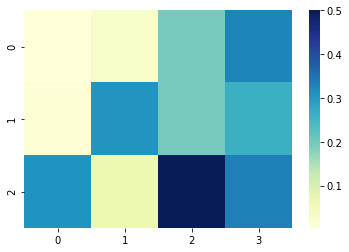

In [7]:
import seaborn as sns
sns.heatmap(model.theta_est, cmap="YlGnBu") # block-interaction parameters

## Implementation with covariates
In addition to the adjacency matrix $Y$, it is possible to provide categorical, binary, count-type or continuous covariates to the model, which ultimately improves the overall performance. They can be provided both for user entity and for item entity: it sufficies to specify their type in a specific parameter of the "fit" method.

In the following toy example, we provide two covariates for the user entity. Priors on cluster assignments are set to GN and appropriate parameters are passed.

Note that, since the covariates are randomly generated, they are trivially non-informative, and hence they reduce the likelihood of the model, deteriorating the predictive performance as well.

In [8]:
x1 = np.array([ 1.04, -1.93,  0.61, -1.04,  2.53, -2.33,  0.63,  0.4 ,  0.09,
       -0.9 , -0.5 , -0.52, -0.6 , -0.3 ,  0.41,  0.41,  1.15, -0.8 ,
       -0.42, -0.4 , -0.63,  0.89,  0.01, -0.91,  0.12, -0.83,  0.01,
       -0.64, -2.2 , -0.62,  0.72,  0.45, -0.56,  0.77,  0.81, -0.88,
       -0.39,  0.2 , -0.38,  0.69, -2.11, -0.57, -0.74,  0.79,  0.3 ,
       -0.32,  0.44,  1.09,  0.11]) # continuous covariate for users

x2 = np.array([[5, 8, 6, 6, 3, 8, 2, 6, 4, 6, 5, 3, 3, 9, 5, 6, 9, 0, 3, 4, 0, 9,
       2, 2, 6, 8, 2, 5, 1, 6, 8, 9, 3, 1, 7, 9, 7, 1, 4, 2, 7, 5, 2, 0,
       3, 3, 7, 8, 2]]) # count-type covariate for users

x = np.empty(shape= (2,Y.shape[0]))

mod1 = esbmr(prior_u = "GN", prior_i = "GN", beta = 0.1, components = 2, sigma = 0.4, gamma = 0)
mod1.fit(Y, 100, xu = x, xi = None, xu_type = ["cont","count"], xi_type = None, verbose = False)

mod1.theta_est # block interaction parameters

------------------
2 covariates for 'user' entity provided:
 - Continuous covariate 0 for users preprocessed.
 - Count-type covariate 1 for users preprocessed.
------------------
Initial log-likelihood: -10804.275963861724
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -7065.902008780809.
Iteration 10 complete. Log-likelihood: -6855.5312735736015.
Iteration 20 complete. Log-likelihood: -6844.070312741389.
Iteration 30 complete. Log-likelihood: -6829.238372709035.
Iteration 40 complete. Log-likelihood: -6825.897480052488.
Iteration 50 complete. Log-likelihood: -6818.396298903395.
Iteration 60 complete. Log-likelihood: -6812.591705332015.
Iteration 70 complete. Log-likelihood: -6837.434926117076.
Iteration 80 complete. Log-likelihood: -6822.176396202449.
Iteration 90 complete. Log-likelihood: -6818.0143824803845.
Runtime: 13.923455
Block-interactions computed.


array([[0.00221582, 0.02852737, 0.17922078],
       [0.35789474, 0.07142857, 0.11111111]])

### Prediction and Mean Squared Error computation
In-sample MSE can be computed with the method 'mse', after the interactions have been predicted with the dedicated method 'predict'.

The out-of-sample MSE can be computed as well, provided an appropriate train/validation split before the MCMC procedure, as in the following example.

In [12]:
def train_val_split(data, valid_dim=0.2):
        '''
        Creating two additional objects, i.e. training and validation set, which can be used in the fitting process

        Parameters:
        data = np.array
        valid_dim = float
        '''
        if valid_dim >= 1:
          raise ValueError("valid_dim must be lower than 1")

        train = data.copy()
        valid = np.zeros(data.shape)

        for u in np.unique(data.nonzero()[0]):
            ind = data[u].nonzero()[0] 

            if len(ind) > 0: 
                valid_ind = np.random.choice(ind, round(len(ind)*valid_dim), replace=False)
                for i in valid_ind:
                    valid[u,i], train[u,i] = data[u,i], 0
        return train, valid

train, test = train_val_split(Y, valid_dim = 0.2)
model = esbmr()
model.fit(train, 100)
y_pred = model.predict(test)

------------------
Initial log-likelihood: -10785.560989986607
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -6974.150714416317.
Iteration 10 complete. Log-likelihood: -6772.718309251438.
Iteration 20 complete. Log-likelihood: -6771.165536513615.
Iteration 30 complete. Log-likelihood: -6777.232199953111.
Iteration 40 complete. Log-likelihood: -6761.912684338221.
Iteration 50 complete. Log-likelihood: -6766.982310531878.
Iteration 60 complete. Log-likelihood: -6758.233041052988.
Iteration 70 complete. Log-likelihood: -6772.027173342385.
Iteration 80 complete. Log-likelihood: -6770.622128458364.
Iteration 90 complete. Log-likelihood: -6762.1792929679605.
Runtime: 10.491347999999995
Block-interactions computed.


Performances are pretty similar to other competing models, with the advantage of a much clearer interpretation of the output parameters as block interactions.

In [13]:
model.mse(values = train, pred = y_pred)

0.7477353015974535

### Convergence diagnostics
We plot a term which is proportional to the log-likelihood in order to assess the convergence of the model. 

Further diagnostics can be delivered for larger networks.

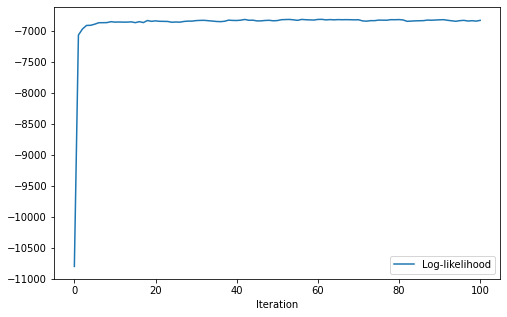

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
ax.plot(mod1.ll, label = "Log-likelihood")
plt.xlabel("Iteration")
ax.legend();